# Using the Pre-Trained Models

Libraries Used

In [10]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np

import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD,RMSprop

from skimage.io import imread,imshow
from skimage.transform import rotate
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
df = pd.read_csv('target.csv').drop('Unnamed: 0',axis=1).set_index('names')
import glob
lista = []
names = glob.glob('finalimages/*.jpg')
for x in names:
    str1 = x.split('\\')[1]
    lista.append(int(str1.split('.')[0]))

In [12]:
df = df.loc[lista]
df2 = df[df['Php/Area']>100000]
df3 = df2[df2['Php/Area']<200000]
df4 = df3.copy()
list_2 = []
        
for x,y in df3.iterrows():
    val = y.values[0]
    if val>=100000 and val<140000:
        list_2.append(0)
    elif val>=140000:
        list_2.append(1)

df4['Class_2'] = list_2
df4.head()

,Php/Area,Class_2
names,,
0,170966.777774,1
1020,134812.981616,0
1025,113333.333333,0
1026,163293.650794,1
1029,163662.468742,1


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
df_train, df_test, df_y_train, df_y_test = train_test_split(df4.index, 
                                                    df4['Class_2'], 
                                                    test_size=0.20,
                                                    stratify=df4['Class_2'],random_state=100)

In [15]:
df5 = df4.loc[df_train]
df6 = df4.loc[df_test]
df6['Class_2'].value_counts()

1    53
0    50
Name: Class_2, dtype: int64

In [16]:
df5

,Php/Area,Class_2
names,,
3386,119523.809524,0
2048,107142.857143,0
2612,186111.111111,1
1917,103960.396040,0
2564,194556.451613,1
...,...,...
346,199565.972222,1
1853,107158.195244,0
2528,115482.151980,0


In [17]:
def prepro(img,num):
    
    preprocess1 = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    preprocess2 = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(1,2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing()])

    preprocess3 = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomPerspective(fill=200),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing()])
    
    preprocess4 = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(180,shear=30,fillcolor=125),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing()])
    
    preprocess5 = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(180,shear=30,fillcolor=125),
        transforms.RandomPerspective(fill=200),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(1,2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing()])
    
    preprocess6 = transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(1,2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing()])
    
    preprocess7 = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing()])
    
    if num==1:
        return preprocess1(img)
    elif num==2:
        return preprocess2(img)
    elif num==3:
        return preprocess3(img)
    elif num==4:
        return preprocess4(img)
    elif num==5:
        return preprocess5(img)
    elif num==6:
        return preprocess6(img)
    elif num==7:
        return preprocess7(img)

## VGG16

In [18]:
model1 = models.vgg16(pretrained=True)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [19]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [20]:
shape1 = model1.features(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 512, 7, 7])

In [11]:
final_data_train = np.empty((len(df5)*18*4*4,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

11907366912

In [12]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*4) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,5):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1.features(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('vgg16_features_train_b.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 118656/118656 [3:25:27<00:00,  9.63it/s] 


Finished


In [21]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

186052608

In [22]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
            rotated = rotate(aws,0,preserve_range=True).astype(np.uint8)
            input_image = Image.fromarray(rotated)
            input_tensor = prepro(input_image,1)
            input_batch = input_tensor.unsqueeze(0) 

            features =  model1.features(input_batch.to(device))
            features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

            final_data_test[count,...]=features2.cpu()

            two_b.append(y['Class_2'])
            area_b.append(y['Php/Area'])
            count +=1

            pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('vgg16_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [03:11<00:00,  9.67it/s]


Finished


## VGG19

In [23]:
model1 = models.vgg19(pretrained=True)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [24]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [25]:
shape1 = model1.features(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 512, 7, 7])

In [18]:
var = 4
final_data_train = np.empty((len(df5)*18*4*var,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

11907366912

In [20]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*var) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,var+1):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1.features(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('vgg19_features_train_b.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 118656/118656 [3:33:51<00:00,  9.25it/s] 


Finished


In [26]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

186052608

In [27]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
            rotated = rotate(aws,0,preserve_range=True).astype(np.uint8)
            input_image = Image.fromarray(rotated)
            input_tensor = prepro(input_image,1)
            input_batch = input_tensor.unsqueeze(0) 

            features =  model1.features(input_batch.to(device))
            features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

            final_data_test[count,...]=features2.cpu()

            two_b.append(y['Class_2'])
            area_b.append(y['Php/Area'])
            count +=1

            pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('vgg19_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [03:12<00:00,  9.63it/s]


Finished


# MNASNET

In [28]:
model1 = models.mnasnet1_0(pretrained=True)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [29]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [30]:
shape1 = model1.layers(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 1280, 7, 7])

In [25]:
var = 1
final_data_train = np.empty((len(df5)*18*4*var,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

7442104320

In [27]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*var) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,var+1):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1.layers(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('mnas_features_train.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 29664/29664 [52:41<00:00,  9.38it/s] 


Finished


In [31]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

465131520

In [32]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            for rota in rot:
                aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                input_image = Image.fromarray(rotated)
                input_tensor = prepro(input_image,1)
                input_batch = input_tensor.unsqueeze(0) 

                features =  model1.layers(input_batch.to(device))
                features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                final_data_test[count,...]=features2.cpu()

                two_b.append(y['Class_2'])
                area_b.append(y['Php/Area'])
                count +=1

                pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('mnas_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [03:09<00:00,  9.81it/s]


Finished


# DENSENET121

In [33]:
model1 = models.densenet121(pretrained=True)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [34]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [35]:
shape1 = model1.features(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 1024, 7, 7])

In [48]:
var = 1
final_data_train = np.empty((len(df5)*18*4*var,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

5953683456

In [50]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*var) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,var+1):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1.features(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('densenet121_features_train.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 29664/29664 [1:06:22<00:00,  7.45it/s]


Finished


In [36]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

372105216

In [37]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            for rota in rot:
                aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                input_image = Image.fromarray(rotated)
                input_tensor = prepro(input_image,1)
                input_batch = input_tensor.unsqueeze(0) 

                features =  model1.features(input_batch.to(device))
                features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                final_data_test[count,...]=features2.cpu()

                two_b.append(y['Class_2'])
                area_b.append(y['Php/Area'])
                count +=1

                pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('densenet121_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [03:36<00:00,  8.55it/s]


Finished


# Squeezenet

In [38]:
model1 = models.squeezenet1_0(pretrained=True)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [39]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [40]:
shape1 = model1.features(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 512, 13, 13])

In [72]:
var = 1
final_data_train = np.empty((len(df5)*18*4*var,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

10267066368

In [73]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*var) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,var+1):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1.features(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('squeezenet_features_train.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 29664/29664 [56:01<00:00,  8.82it/s] 


Finished


In [41]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

641691648

In [42]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            for rota in rot:
                aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                input_image = Image.fromarray(rotated)
                input_tensor = prepro(input_image,1)
                input_batch = input_tensor.unsqueeze(0) 

                features =  model1.features(input_batch.to(device))
                features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                final_data_test[count,...]=features2.cpu()

                two_b.append(y['Class_2'])
                area_b.append(y['Php/Area'])
                count +=1

                pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('squuezenet_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [02:53<00:00, 10.67it/s]


Finished


# Shufflenet

In [43]:
model1 = models.shufflenet_v2_x1_0(pretrained=True)
modules = list(model1.children())[:-1]
model1 = torch.nn.Sequential(*modules)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [44]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [45]:
shape1 = model1(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 1024, 7, 7])

In [82]:
var = 1
final_data_train = np.empty((len(df5)*18*4*var,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

5953683456

In [83]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*var) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,var+1):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('shufflenet_features_train.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 29664/29664 [58:55<00:00,  8.39it/s] 


Finished


In [46]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

372105216

In [47]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            for rota in rot:
                aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                input_image = Image.fromarray(rotated)
                input_tensor = prepro(input_image,1)
                input_batch = input_tensor.unsqueeze(0) 

                features =  model1(input_batch.to(device))
                features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                final_data_test[count,...]=features2.cpu()

                two_b.append(y['Class_2'])
                area_b.append(y['Php/Area'])
                count +=1

                pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('shufflenet_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [03:07<00:00,  9.89it/s]


Finished


# Mobilenet

In [48]:
model1 = models.mobilenet_v2(pretrained=True)
modules = list(model1.children())[:-1]
model1 = torch.nn.Sequential(*modules)
model1.to(device)
for param in model1.parameters():
    param.requires_grad = False

In [49]:
new = prepro(Image.fromarray(imread('images_2/0_0.jpg')),1)
new.shape

torch.Size([3, 224, 224])

In [50]:
shape1 = model1(new.unsqueeze(0).to(device)).shape
shape1

torch.Size([1, 1280, 7, 7])

In [94]:
var = 1
final_data_train = np.empty((len(df5)*18*4*var,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_train.nbytes

7442104320

In [95]:
two = []
area = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0,90,180,270]

with tqdm(total=len(df5)*18*4*var) as pbar:
    for x,y in df5.iterrows():
        for ang in headings:
            for rota in rot:
                for pre in range(1,var+1):
                    aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                    rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                    input_image = Image.fromarray(rotated)
                    input_tensor = prepro(input_image,pre)
                    input_batch = input_tensor.unsqueeze(0) 

                    features =  model1(input_batch.to(device))
                    features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                    final_data_train[count,...]=features2.cpu()

                    two.append(y['Class_2'])
                    area.append(y['Php/Area'])

                    count +=1

                    pbar.update(1)
                    
two_a = np.array(two)
area_a = np.array(area)
np.savez_compressed('mobilenet_features_train.npz',final_data_train,two_a,area_a)
print('Finished')

100%|██████████| 29664/29664 [57:38<00:00,  8.58it/s] 


Finished


In [51]:
final_data_test = np.empty((len(df6)*18,shape1[1]*shape1[2]*shape1[3]),dtype=np.float32)
final_data_test.nbytes

465131520

In [52]:
two_b = []
area_b = []
count = 0

headings = ['0','20','40','60','80','100','120','140','160',
            '180','200','220','240','260','280','300','320','340']

rot = [0]

with tqdm(total=len(df6)*18) as pbar:
    for x,y in df6.iterrows():
        for ang in headings:
            for rota in rot:
                aws = (imread('images_2/'+str(x)+'_'+str(ang)+'.jpg'))
                rotated = rotate(aws,rota,preserve_range=True).astype(np.uint8)
                input_image = Image.fromarray(rotated)
                input_tensor = prepro(input_image,1)
                input_batch = input_tensor.unsqueeze(0) 

                features =  model1(input_batch.to(device))
                features2 = np.reshape(features.cpu(),(1,shape1[1]*shape1[2]*shape1[3]))

                final_data_test[count,...]=features2.cpu()

                two_b.append(y['Class_2'])
                area_b.append(y['Php/Area'])
                count +=1

                pbar.update(1)
two_b = np.array(two_b)
area_b = np.array(area_b)
np.savez_compressed('mobilenet_features_test.npz',final_data_test,two_b,area_b)
print('Finished')

100%|██████████| 1854/1854 [03:04<00:00, 10.05it/s]


Finished


# Loading the Datasets

In [53]:
#defining some functions
class ClassifierDataset(Dataset):
    # a class to split create a dataset table
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
def multi_acc(y_pred, y_test):
    
    true = np.argmax(y_test.cpu().detach().numpy(),1)
    pred = np.argmax(y_pred.cpu().detach().numpy(),1)
    
    acc = accuracy_score(true, pred)
    
    return acc

# VGG16 Training

In [54]:
X_train = (np.load('vgg16_features_train_b.npz')['arr_0'])
y_train = np.load('vgg16_features_train_b.npz')['arr_1']
X_test = (np.load('vgg16_features_test.npz')['arr_0'])
y_test = np.load('vgg16_features_test.npz')['arr_1']

In [55]:
print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (118656, 25088)
Trainset Target Shape:  (118656,)
Testset Shape:  (1854, 25088)
Testset Target Shape:  (1854,)
New Target Train shape:  (118656, 2)
New Target Test shape:  (1854, 2)


In [56]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [57]:
accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

In [58]:
EPOCHS = 100

NUM_CLASSES = 1
train_loader = DataLoader(dataset=train_dataset,batch_size=1000,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100,shuffle=True)

In [59]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8),
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [60]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.7437794323728866 Val Loss: 0.691591761614147 Train Acc: 0.556433695429391 Val Acc: 0.5587914230019493
Epoch 2 Train Loss: 0.6657426201996683 Val Loss: 0.6976305246353149 Train Acc: 0.6075585160893622 Val Acc: 0.55458089668616
Epoch 3 Train Loss: 0.6376598627627397 Val Loss: 0.7050126791000366 Train Acc: 0.6351244107399058 Val Acc: 0.5642105263157896
Epoch 4 Train Loss: 0.6247325033700767 Val Loss: 0.708233422354648 Train Acc: 0.6499480426316873 Val Acc: 0.5614230019493177
Epoch 5 Train Loss: 0.6166640640306873 Val Loss: 0.7215046317953813 Train Acc: 0.6582041401926628 Val Acc: 0.5657115009746588
Epoch 6 Train Loss: 0.6075857592230084 Val Loss: 0.72141663965426 Train Acc: 0.6674913916786228 Val Acc: 0.56682261208577
Epoch 7 Train Loss: 0.6011229973881185 Val Loss: 0.7204482649502001 Train Acc: 0.6752646034023365 Val Acc: 0.5623976608187135
Epoch 8 Train Loss: 0.595355440087679 Val Loss: 0.7260090583249142 Train Acc: 0.6796672473867599 Val Acc: 0.555

In [61]:
model.eval()
torch.save(model, 'vgg16_model.pt')

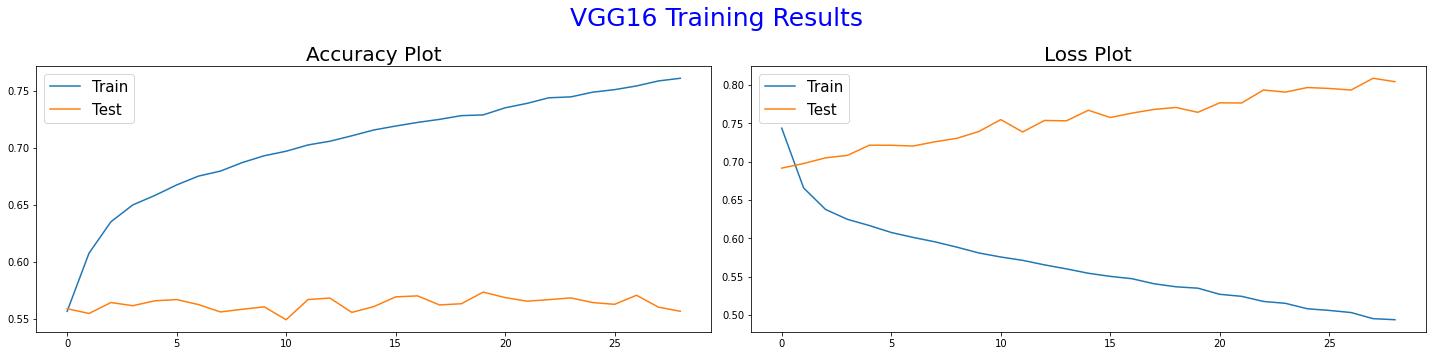

In [62]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
plt.suptitle('VGG16 Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('vgg16plot.png')
plt.show()

# VGG19 Training

In [63]:
X_train = np.load('vgg19_features_train_b.npz')['arr_0']
y_train = np.load('vgg19_features_train_b.npz')['arr_1']
X_test = np.load('vgg19_features_test.npz')['arr_0']
y_test = np.load('vgg19_features_test.npz')['arr_1']

print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (118656, 25088)
Trainset Target Shape:  (118656,)
Testset Shape:  (1854, 25088)
Testset Target Shape:  (1854,)
New Target Train shape:  (118656, 2)
New Target Test shape:  (1854, 2)


In [64]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

EPOCHS = 100

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [65]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8),
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [66]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.6996454288202268 Val Loss: 0.6773718281796104 Train Acc: 0.5533896979179205 Val Acc: 0.5797660818713449
Epoch 2 Train Loss: 0.6765373247254266 Val Loss: 0.6769089259599385 Train Acc: 0.5767715729931395 Val Acc: 0.5696101364522417
Epoch 3 Train Loss: 0.6736983014137281 Val Loss: 0.6804467502393221 Train Acc: 0.5824010109519788 Val Acc: 0.5593957115009748
Epoch 4 Train Loss: 0.6709925437435545 Val Loss: 0.6816801711132652 Train Acc: 0.5870646287158502 Val Acc: 0.5536647173489279
Epoch 5 Train Loss: 0.6679098873753053 Val Loss: 0.6831656443445306 Train Acc: 0.5948357203032858 Val Acc: 0.552923976608187
Epoch 6 Train Loss: 0.666549873432394 Val Loss: 0.682437118731047 Train Acc: 0.594324828499218 Val Acc: 0.5537621832358675
Epoch 7 Train Loss: 0.6643955271185801 Val Loss: 0.6778542838598552 Train Acc: 0.5972355277410032 Val Acc: 0.561111111111111
Epoch 8 Train Loss: 0.6640010453013683 Val Loss: 0.6810829702176546 Train Acc: 0.5991858226019965 Val Acc: 

Epoch 66 Train Loss: 0.604597387363053 Val Loss: 0.7186799959132546 Train Acc: 0.6743206161993018 Val Acc: 0.5472904483430799
Epoch 67 Train Loss: 0.6011265920257006 Val Loss: 0.7152781580623827 Train Acc: 0.67963352990733 Val Acc: 0.5541130604288499
Epoch 68 Train Loss: 0.6019348518980986 Val Loss: 0.7131266311595315 Train Acc: 0.6775574678059945 Val Acc: 0.5436062378167641
Epoch 69 Train Loss: 0.602955124111063 Val Loss: 0.7127080998922649 Train Acc: 0.6774214706944285 Val Acc: 0.547719298245614
Epoch 70 Train Loss: 0.6011810065721803 Val Loss: 0.7187548467987462 Train Acc: 0.6775201588638833 Val Acc: 0.5481871345029239
Epoch 71 Train Loss: 0.6000440707453781 Val Loss: 0.7179975666497883 Train Acc: 0.6782362498495619 Val Acc: 0.5572904483430798
Epoch 72 Train Loss: 0.6003824110129549 Val Loss: 0.715090346963782 Train Acc: 0.6784065471175842 Val Acc: 0.5529434697855751
Epoch 73 Train Loss: 0.5982835065846496 Val Loss: 0.7178051377597608 Train Acc: 0.6813948730292466 Val Acc: 0.5502144

In [67]:
model.eval()
torch.save(model, 'vgg19_model.pt')

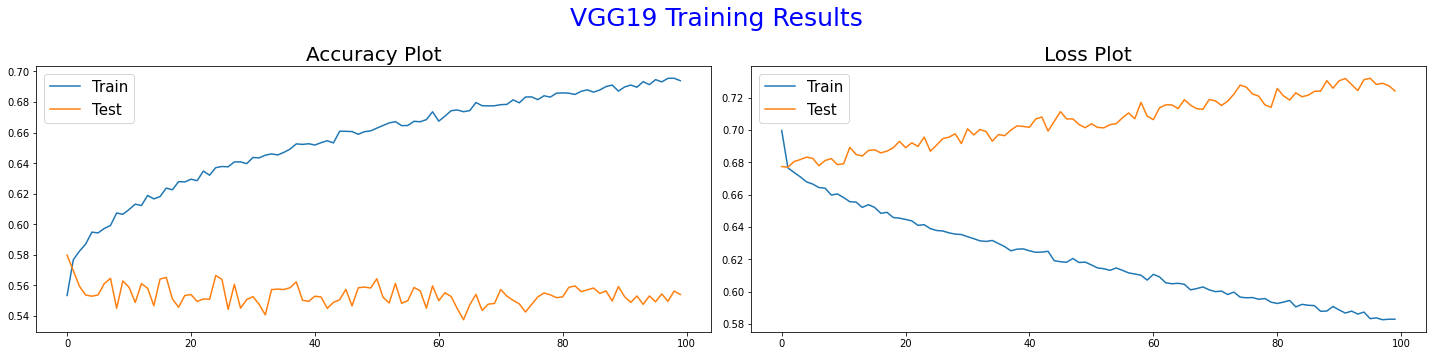

In [68]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
plt.suptitle('VGG19 Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('vgg19plot.png')
plt.show()

# MNASNET Training

In [69]:
X_train = np.load('mnas_features_train.npz')['arr_0']
y_train = np.load('mnas_features_train.npz')['arr_1']
X_test = np.load('mnas_features_test.npz')['arr_0']
y_test = np.load('mnas_features_test.npz')['arr_1']

print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (29664, 62720)
Trainset Target Shape:  (29664,)
Testset Shape:  (1854, 62720)
Testset Target Shape:  (1854,)
New Target Train shape:  (29664, 2)
New Target Test shape:  (1854, 2)


In [70]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

EPOCHS = 100

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [75]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8), # intializing the big dropout amount to reduce overfitting significantly
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [76]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.7547056151158882 Val Loss: 0.6935016042307803 Train Acc: 0.5058059764309761 Val Acc: 0.4854191033138402
Epoch 2 Train Loss: 0.7018468462256872 Val Loss: 0.6929480088384528 Train Acc: 0.5000105218855222 Val Acc: 0.5115204678362574
Epoch 3 Train Loss: 0.6952353452993965 Val Loss: 0.6927538388653806 Train Acc: 0.5017718855218852 Val Acc: 0.5146588693957115
Epoch 4 Train Loss: 0.6947591822556775 Val Loss: 0.6929654886848048 Train Acc: 0.5001662457912459 Val Acc: 0.5155555555555555
Epoch 5 Train Loss: 0.6946560170514013 Val Loss: 0.6928093998055709 Train Acc: 0.5046969696969698 Val Acc: 0.5133138401559454
Epoch 6 Train Loss: 0.6949518312910189 Val Loss: 0.6928963943531639 Train Acc: 0.5000589225589226 Val Acc: 0.5124171539961013
Epoch 7 Train Loss: 0.6949625428678211 Val Loss: 0.6966106640665155 Train Acc: 0.5003177609427606 Val Acc: 0.48309941520467836
Epoch 8 Train Loss: 0.6946370206296645 Val Loss: 0.6927441107599359 Train Acc: 0.5033375420875422 Val

Epoch 66 Train Loss: 0.6951715075207078 Val Loss: 0.693538929286756 Train Acc: 0.4958249158249158 Val Acc: 0.5119688109161793
Epoch 67 Train Loss: 0.6945665253934635 Val Loss: 0.6927398600076374 Train Acc: 0.5044823232323232 Val Acc: 0.5146588693957115
Epoch 68 Train Loss: 0.6944650662467134 Val Loss: 0.6930344763555025 Train Acc: 0.5042150673400674 Val Acc: 0.5124171539961013
Epoch 69 Train Loss: 0.6951493911871605 Val Loss: 0.6933967973056593 Train Acc: 0.4971401515151517 Val Acc: 0.5137621832358675
Epoch 70 Train Loss: 0.6947785529624734 Val Loss: 0.6928054188427172 Train Acc: 0.4988552188552191 Val Acc: 0.5160038986354776
Epoch 71 Train Loss: 0.6952181651134683 Val Loss: 0.6927922838612607 Train Acc: 0.4999053030303028 Val Acc: 0.5173489278752438
Epoch 72 Train Loss: 0.6947179320284012 Val Loss: 0.6927772854503832 Train Acc: 0.5019149831649831 Val Acc: 0.5142105263157896
Epoch 73 Train Loss: 0.6944446643996319 Val Loss: 0.6929350589451037 Train Acc: 0.5048127104377103 Val Acc: 0.51

In [77]:
model.eval()
torch.save(model, 'mnas_model.pt')

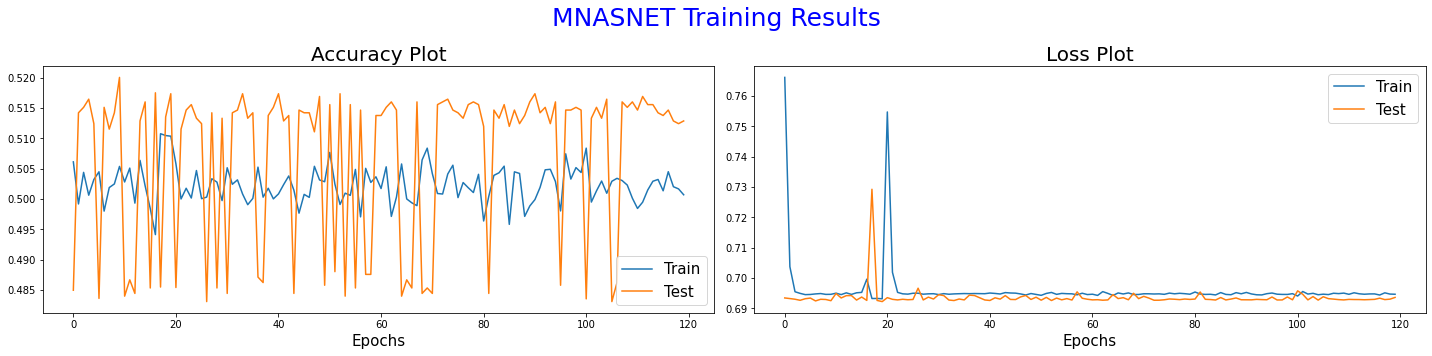

In [78]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[0].set_xlabel('Epochs',fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
ax[1].set_xlabel('Epochs',fontsize=15)
plt.suptitle('MNASNET Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('mnasplot.png')
plt.show()

# DENSENET Training

In [79]:
X_train = np.load('densenet121_features_train.npz')['arr_0']
y_train = np.load('densenet121_features_train.npz')['arr_1']
X_test = np.load('densenet121_features_test.npz')['arr_0']
y_test = np.load('densenet121_features_test.npz')['arr_1']

print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (29664, 50176)
Trainset Target Shape:  (29664,)
Testset Shape:  (1854, 50176)
Testset Target Shape:  (1854,)
New Target Train shape:  (29664, 2)
New Target Test shape:  (1854, 2)


In [80]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

EPOCHS = 100

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [81]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8),
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [82]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.7619478734655413 Val Loss: 0.6920454282509653 Train Acc: 0.5082449494949492 Val Acc: 0.5357115009746588
Epoch 2 Train Loss: 0.7012215521600511 Val Loss: 0.6907789017024794 Train Acc: 0.5142508417508421 Val Acc: 0.5638206627680312
Epoch 3 Train Loss: 0.6924497426961006 Val Loss: 0.6906446563570123 Train Acc: 0.5243644781144784 Val Acc: 0.5329434697855749
Epoch 4 Train Loss: 0.6905172134087945 Val Loss: 0.6874992941555224 Train Acc: 0.530498737373737 Val Acc: 0.5575828460038986
Epoch 5 Train Loss: 0.6900418635570642 Val Loss: 0.6880496803082918 Train Acc: 0.5327293771043776 Val Acc: 0.5567641325536062
Epoch 6 Train Loss: 0.6902330347183177 Val Loss: 0.6890477789075751 Train Acc: 0.532582070707071 Val Acc: 0.5558674463937623
Epoch 7 Train Loss: 0.6883389803295585 Val Loss: 0.6888294408195897 Train Acc: 0.5391329966329966 Val Acc: 0.5444249512670566
Epoch 8 Train Loss: 0.6859329374952349 Val Loss: 0.691529044979497 Train Acc: 0.5466287878787885 Val Acc

Epoch 66 Train Loss: 0.6384958735218754 Val Loss: 0.6913015120907834 Train Acc: 0.6345391414141414 Val Acc: 0.5499999999999999
Epoch 67 Train Loss: 0.6380199906400559 Val Loss: 0.6881248982329118 Train Acc: 0.6385585016835014 Val Acc: 0.557504873294347
Epoch 68 Train Loss: 0.6356194127689708 Val Loss: 0.695087404627549 Train Acc: 0.6418686868686867 Val Acc: 0.5312865497076023
Epoch 69 Train Loss: 0.6310699260997451 Val Loss: 0.6940857987654837 Train Acc: 0.6429356060606058 Val Acc: 0.5540545808966861
Epoch 70 Train Loss: 0.6309213543981815 Val Loss: 0.6923500424937198 Train Acc: 0.6444612794612792 Val Acc: 0.5448148148148149
Epoch 71 Train Loss: 0.6308607874494611 Val Loss: 0.6881412706877056 Train Acc: 0.6462478956228955 Val Acc: 0.5493957115009748
Epoch 72 Train Loss: 0.6291963361730479 Val Loss: 0.689050200738405 Train Acc: 0.6465867003367003 Val Acc: 0.5500779727095517
Epoch 73 Train Loss: 0.6311128157557864 Val Loss: 0.6889707822548715 Train Acc: 0.6462352693602689 Val Acc: 0.5507

In [83]:
model.eval()
torch.save(model, 'densenet121_model.pt')

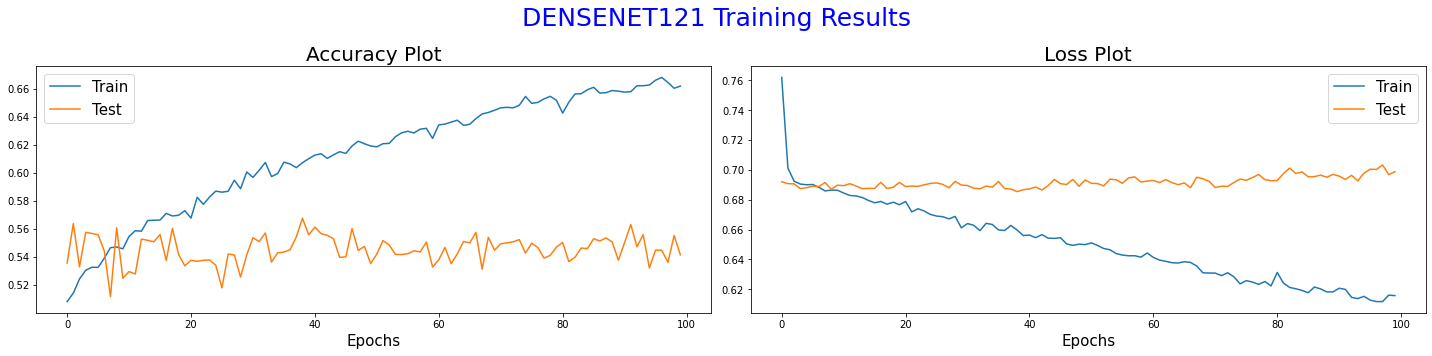

In [84]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[0].set_xlabel('Epochs',fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
ax[1].set_xlabel('Epochs',fontsize=15)
plt.suptitle('DENSENET121 Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('denseplot.png')
plt.show()

# SQUEEZENET Training

In [85]:
X_train = np.load('squeezenet_features_train.npz')['arr_0']
y_train = np.load('squeezenet_features_train.npz')['arr_1']
X_test = np.load('squuezenet_features_test.npz')['arr_0']
y_test = np.load('squuezenet_features_test.npz')['arr_1']

print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (29664, 86528)
Trainset Target Shape:  (29664,)
Testset Shape:  (1854, 86528)
Testset Target Shape:  (1854,)
New Target Train shape:  (29664, 2)
New Target Test shape:  (1854, 2)


In [86]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

EPOCHS = 100

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [87]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8),
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [88]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.7664722730013658 Val Loss: 0.6913594823134573 Train Acc: 0.5052188552188557 Val Acc: 0.5151851851851853
Epoch 2 Train Loss: 0.7030225689162309 Val Loss: 0.6909072085430747 Train Acc: 0.5054208754208755 Val Acc: 0.5163157894736843
Epoch 3 Train Loss: 0.6949723467280969 Val Loss: 0.6911576421637284 Train Acc: 0.5086111111111112 Val Acc: 0.5727680311890837
Epoch 4 Train Loss: 0.6941615449459063 Val Loss: 0.6923160333382455 Train Acc: 0.5102398989898989 Val Acc: 0.5142105263157895
Epoch 5 Train Loss: 0.693972485434728 Val Loss: 0.6915505308853952 Train Acc: 0.5090614478114476 Val Acc: 0.5151072124756336
Epoch 6 Train Loss: 0.6947275566733646 Val Loss: 0.6933331834642511 Train Acc: 0.5033122895622898 Val Acc: 0.4830994152046784
Epoch 7 Train Loss: 0.694036764929993 Val Loss: 0.6917651797595777 Train Acc: 0.5073526936026939 Val Acc: 0.5119688109161793
Epoch 8 Train Loss: 0.6951551397240122 Val Loss: 0.6910184872777838 Train Acc: 0.5015972222222222 Val Ac

Epoch 66 Train Loss: 0.6949576267891059 Val Loss: 0.6927272614679838 Train Acc: 0.49909090909090886 Val Acc: 0.5164522417153997
Epoch 67 Train Loss: 0.694901745528083 Val Loss: 0.6924948409983986 Train Acc: 0.49950126262626293 Val Acc: 0.5164522417153997
Epoch 68 Train Loss: 0.6946005893476082 Val Loss: 0.6927919921122099 Train Acc: 0.500494528619529 Val Acc: 0.5115204678362574
Epoch 69 Train Loss: 0.693971741279769 Val Loss: 0.6941611264881334 Train Acc: 0.5100441919191919 Val Acc: 0.48444444444444446
Epoch 70 Train Loss: 0.6941352494637975 Val Loss: 0.6930212566727086 Train Acc: 0.5105829124579127 Val Acc: 0.4866861598440546
Epoch 71 Train Loss: 0.694803308156203 Val Loss: 0.6929623955174496 Train Acc: 0.5018181818181819 Val Acc: 0.48317738791423004
Epoch 72 Train Loss: 0.6944497155420708 Val Loss: 0.6926138118693703 Train Acc: 0.5030113636363635 Val Acc: 0.5160038986354777
Epoch 73 Train Loss: 0.6945026360376917 Val Loss: 0.6925129796329298 Train Acc: 0.5031418350168352 Val Acc: 0.5

In [89]:
model.eval()
torch.save(model, 'squeezenet_model.pt')

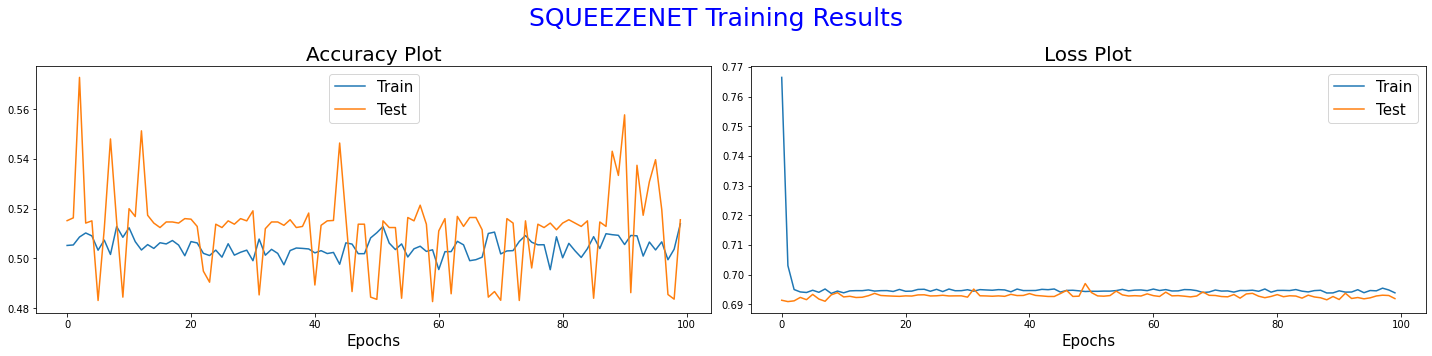

In [90]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[0].set_xlabel('Epochs',fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
ax[1].set_xlabel('Epochs',fontsize=15)
plt.suptitle('SQUEEZENET Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('squeezeplot.png')
plt.show()

# SHUFFLENET Training

In [91]:
X_train = np.load('shufflenet_features_train.npz')['arr_0']
y_train = np.load('shufflenet_features_train.npz')['arr_1']
X_test = np.load('shufflenet_features_test.npz')['arr_0']
y_test = np.load('shufflenet_features_test.npz')['arr_1']

print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (29664, 50176)
Trainset Target Shape:  (29664,)
Testset Shape:  (1854, 50176)
Testset Target Shape:  (1854,)
New Target Train shape:  (29664, 2)
New Target Test shape:  (1854, 2)


In [92]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

EPOCHS = 100

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [93]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8),
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [94]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.7006874441699147 Val Loss: 0.6822928190231323 Train Acc: 0.5312205387205386 Val Acc: 0.5653996101364523
Epoch 2 Train Loss: 0.6358969004868659 Val Loss: 0.6890177287553486 Train Acc: 0.648956228956229 Val Acc: 0.5657894736842106
Epoch 3 Train Loss: 0.55530615517186 Val Loss: 0.725421667098999 Train Acc: 0.7190530303030296 Val Acc: 0.5663742690058481
Epoch 4 Train Loss: 0.48262282272781987 Val Loss: 0.7874041638876262 Train Acc: 0.7742908249158247 Val Acc: 0.5567446393762183
Stopping Point due to Overfitting


In [95]:
model.eval()
torch.save(model, 'shufflenet_model.pt')

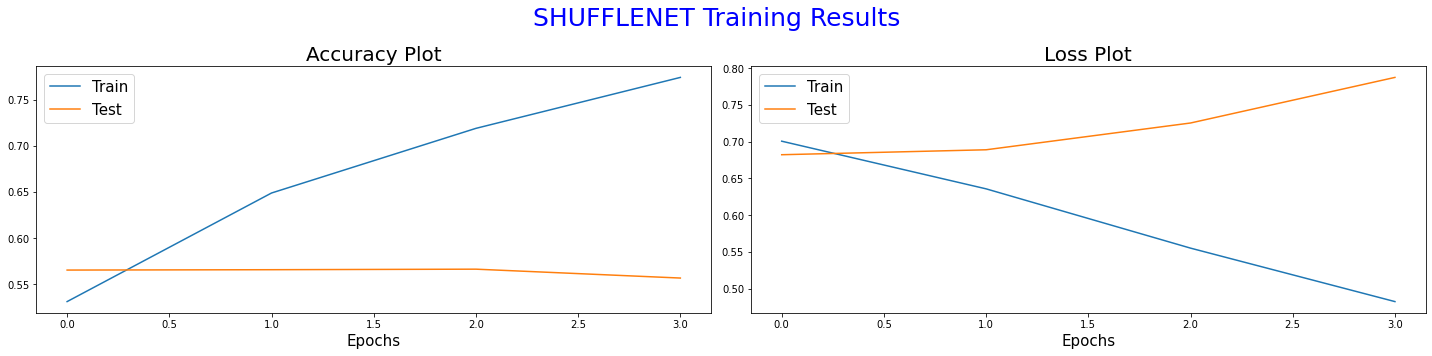

In [96]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[0].set_xlabel('Epochs',fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
ax[1].set_xlabel('Epochs',fontsize=15)
plt.suptitle('SHUFFLENET Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('shuffleplot.png')
plt.show()

# MOBILENET Training

In [97]:
X_train = np.load('mobilenet_features_train.npz')['arr_0']
y_train = np.load('mobilenet_features_train.npz')['arr_1']
X_test = np.load('mobilenet_features_test.npz')['arr_0']
y_test = np.load('mobilenet_features_test.npz')['arr_1']

print('Trainset Shape: ',X_train.shape)
print('Trainset Target Shape: ',y_train.shape)
print('Testset Shape: ',X_test.shape)
print('Testset Target Shape: ',y_test.shape)

y_train = to_categorical(np.reshape(y_train,(y_train.shape[0],1)))
print('New Target Train shape: ',y_train.shape)

y_test = to_categorical(np.reshape(y_test,(y_test.shape[0],1)))
print('New Target Test shape: ',y_test.shape)

Trainset Shape:  (29664, 62720)
Trainset Target Shape:  (29664,)
Testset Shape:  (1854, 62720)
Testset Target Shape:  (1854,)
New Target Train shape:  (29664, 2)
New Target Test shape:  (1854, 2)


In [98]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

accuracy_stats = {'train': [],"val": []}
loss_stats = {'train': [],"val": []}

EPOCHS = 100

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [99]:
model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 128),
        torch.nn.Tanh(),
        torch.nn.Dropout(0.8),
        torch.nn.Linear(128, 2),
        torch.nn.Sigmoid()
)
model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [100]:
print("Begin training.")
for e in (range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0 # for loss tracking
    train_epoch_acc = 0 #for acc traking
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.float())
        train_acc = multi_acc(y_train_pred, y_train_batch.float())
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred,y_val_batch.float())
            val_acc = multi_acc(y_val_pred, y_val_batch.float())

            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
  
    print('Epoch',e,'Train Loss:',(train_epoch_loss/len(train_loader)),
          'Val Loss:',(val_epoch_loss/len(val_loader)),
          'Train Acc:',(train_epoch_acc/len(train_loader)),
          'Val Acc:',(val_epoch_acc/len(val_loader)))
    
    stopping = (train_epoch_acc/len(train_loader)) - (val_epoch_acc/len(val_loader))
    
    if stopping >= 0.20:
        model.eval()
        print('Stopping Point due to Overfitting')
        break

Begin training.
Epoch 1 Train Loss: 0.7630394526603648 Val Loss: 0.6939756148739865 Train Acc: 0.5024137205387209 Val Acc: 0.48534113060428846
Epoch 2 Train Loss: 0.7034082288292522 Val Loss: 0.6939951118670011 Train Acc: 0.49838804713804746 Val Acc: 0.4848927875243665
Epoch 3 Train Loss: 0.6950925137057449 Val Loss: 0.6942446608292429 Train Acc: 0.504915824915825 Val Acc: 0.48309941520467836
Epoch 4 Train Loss: 0.6951668449122497 Val Loss: 0.6934100954156173 Train Acc: 0.5006250000000001 Val Acc: 0.48130604288499024
Epoch 5 Train Loss: 0.6947367685009734 Val Loss: 0.6928805018726149 Train Acc: 0.5009364478114479 Val Acc: 0.5115204678362574
Epoch 6 Train Loss: 0.6944313906258606 Val Loss: 0.6928475059961018 Train Acc: 0.5053893097643101 Val Acc: 0.5128654970760235
Epoch 7 Train Loss: 0.694728793720605 Val Loss: 0.6928400522784183 Train Acc: 0.5003009259259262 Val Acc: 0.5124171539961013
Epoch 8 Train Loss: 0.6947365292796382 Val Loss: 0.6931975609377811 Train Acc: 0.5018665824915827 Va

Epoch 66 Train Loss: 0.6945145047874964 Val Loss: 0.6931282470100805 Train Acc: 0.5015130471380471 Val Acc: 0.5110721247563352
Epoch 67 Train Loss: 0.6947149837057197 Val Loss: 0.6933140974295767 Train Acc: 0.5041792929292925 Val Acc: 0.5124171539961013
Epoch 68 Train Loss: 0.6945449252321263 Val Loss: 0.6925859796373468 Train Acc: 0.5043939393939393 Val Acc: 0.5169005847953216
Epoch 69 Train Loss: 0.6948128328580246 Val Loss: 0.6929466128349304 Train Acc: 0.5034280303030305 Val Acc: 0.5155555555555557
Epoch 70 Train Loss: 0.6948744028505652 Val Loss: 0.6947839071876124 Train Acc: 0.5058459595959597 Val Acc: 0.4853411306042884
Epoch 71 Train Loss: 0.6948928249002707 Val Loss: 0.6927298966207003 Train Acc: 0.505105218855219 Val Acc: 0.5155555555555557
Epoch 72 Train Loss: 0.6944251766911259 Val Loss: 0.6929105332023219 Train Acc: 0.5090277777777781 Val Acc: 0.5137621832358674
Epoch 73 Train Loss: 0.6950205963870091 Val Loss: 0.692718926228975 Train Acc: 0.5010248316498319 Val Acc: 0.515

In [101]:
model.eval()
torch.save(model, 'mobilenet_model.pt')

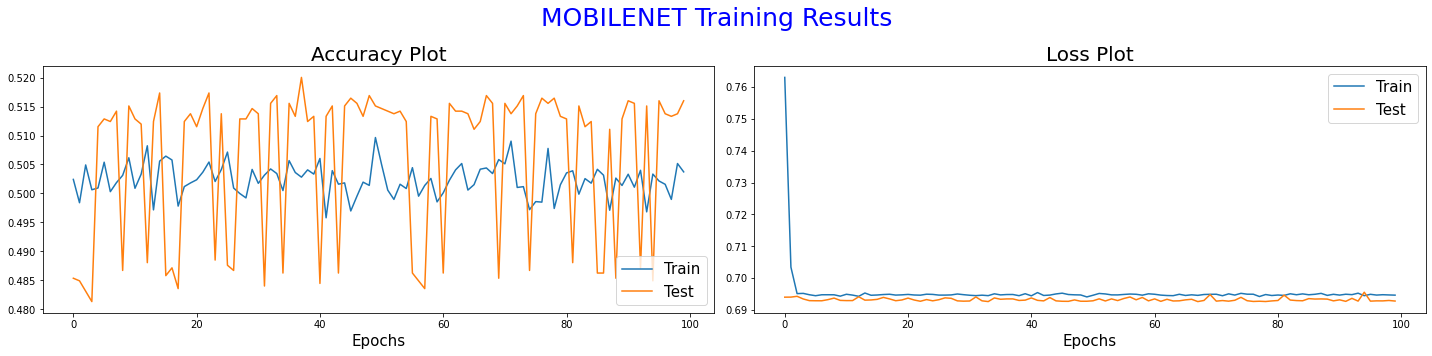

In [102]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(accuracy_stats['train'])
ax[0].plot(accuracy_stats['val'])
ax[0].set_title('Accuracy Plot',fontsize=20)
ax[0].legend(['Train','Test'],fontsize=15)
ax[0].set_xlabel('Epochs',fontsize=15)
ax[1].plot(loss_stats['train'])
ax[1].plot(loss_stats['val'])
ax[1].set_title('Loss Plot',fontsize=20)
ax[1].legend(['Train','Test'],fontsize=15)
ax[1].set_xlabel('Epochs',fontsize=15)
plt.suptitle('MOBILENET Training Results',fontsize=25,color='blue')
plt.tight_layout()
plt.savefig('mobileplot.png')
plt.show()